In [1]:
from jedi import jedi

import types
import matplotlib.pylab as plt
import numpy as np
from __future__ import division
from scipy.integrate import odeint,ode
from numpy import zeros,ones,eye,tanh,dot,outer,sqrt,linspace, \
    cos,pi,hstack,zeros_like,abs,repeat
from numpy.random import uniform,normal,choice
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [110]:
# Setting Seeds
seeds = uniform(0,10000,20).astype(int)

In [111]:
# Simulation Parameters for FORCE/DFORCE

def set_simulation_parameters(seed, N, i):
    prng = np.random.RandomState(seed)

    J = prng.normal(0, sqrt(1 / N), (N, N))
    Wi = prng.normal(0, sqrt(1 / i), (i, i))
    wi = prng.normal(0, sqrt(1 / i), (i, i))
    x0 = prng.uniform(-0.5, 0.5, N)

    u = prng.uniform(-1, 1, N)
    w = prng.uniform(-1 / sqrt(N), 1 / sqrt(N), N)  # Initial weights

    return J, Wi, wi, x0, u, w

In [94]:
# Printers

def mean_signal_error(errs, t, tstop, title, burn_in=0, mean=True):
    plt.figure(figsize=(12,6))
    if mean:
        errs = np.mean(errs, axis=0)
    ymax = 2*np.max(errs[burn_in:])
    plt.plot(t[burn_in:], errs[burn_in:], label="Signal/Output Error")
    plt.vlines(tstop,0, ymax, label="Training Stop")
    plt.ylim(0,ymax)
    plt.xlabel('time', fontweight='bold', fontsize=16)
    plt.ylabel('error', fontweight='bold', fontsize=16)
    plt.title(title, fontweight='bold', fontsize=20)
    plt.legend()
    
def cross_mean_signal_error(errs1, errs2, t, tstop, title, burn_in=0, mean=True):
    plt.figure(figsize=(12,6))
    if mean:
        errs1 = np.mean(errs1, axis=0)
        errs2 = np.mean(errs2, axis=0)
    ymax = 2*np.max([np.max(errs1[burn_in:]), np.max(errs2[burn_in:])])
    print ymax
    plt.plot(t[burn_in:], errs1[burn_in:], label="S/O Error (FORCE)", alpha=.8)
    plt.plot(t[burn_in:], errs2[burn_in:], label="S/O Error (DFORCE)", alpha=.8)
    plt.vlines(tstop,0, ymax, label="Training Stop")
    plt.ylim(0,ymax)
    plt.xlabel('time', fontweight='bold', fontsize=16)
    plt.ylabel('error', fontweight='bold', fontsize=16)
    plt.title(title, fontweight='bold', fontsize=20)
    plt.legend()
    
def error_signal_plot(t, z, wu, target, offset=0):
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    if isinstance(target, types.FunctionType):
        plt.plot(t, target(t), '-r', lw=2)
    else:
        plt.plot(t[offset:], target, '-r', lw=2)
    plt.plot(t, z, '-b')
    plt.legend(('target', 'output'))
    plt.ylim([-1.1, 3])
    plt.xticks([])
    plt.subplot(2, 1, 2)
    plt.plot(t, wu, '-k')
    plt.yscale('log')
    plt.ylabel('$|\Delta w|$', fontsize=20)
    plt.xlabel('time', fontweight='bold', fontsize=16)
    plt.show()

In [44]:
# Target
target = lambda t0: cos(2 * pi * t0 / 50)

In [45]:
dt = 1       # time step
tmax = 1000   # simulation length
tstop = 500  # learning stop time
g = 1.5      # gain factor?
N = 300      # size of stochastic pool
lr = 1.0     # learning rate

errors = []

for seed in seeds:
    J, _, _, x0, u, w = set_simulation_parameters(seed, N, 1)
    
    # inp & z are dummy variables
    def model(t0, x, tanh_x, w, inp, z): 
        return -x + g * dot(J, tanh_x) + dot(w, tanh_x) * u
    
    x,t,z,_,_ = jedi.force(target, model, lr, dt, tmax, tstop, x0, w)

    error = np.abs(z-target(t))
    errors.append(error)
    
errors = np.array(errors)

In [46]:
jedi.force?

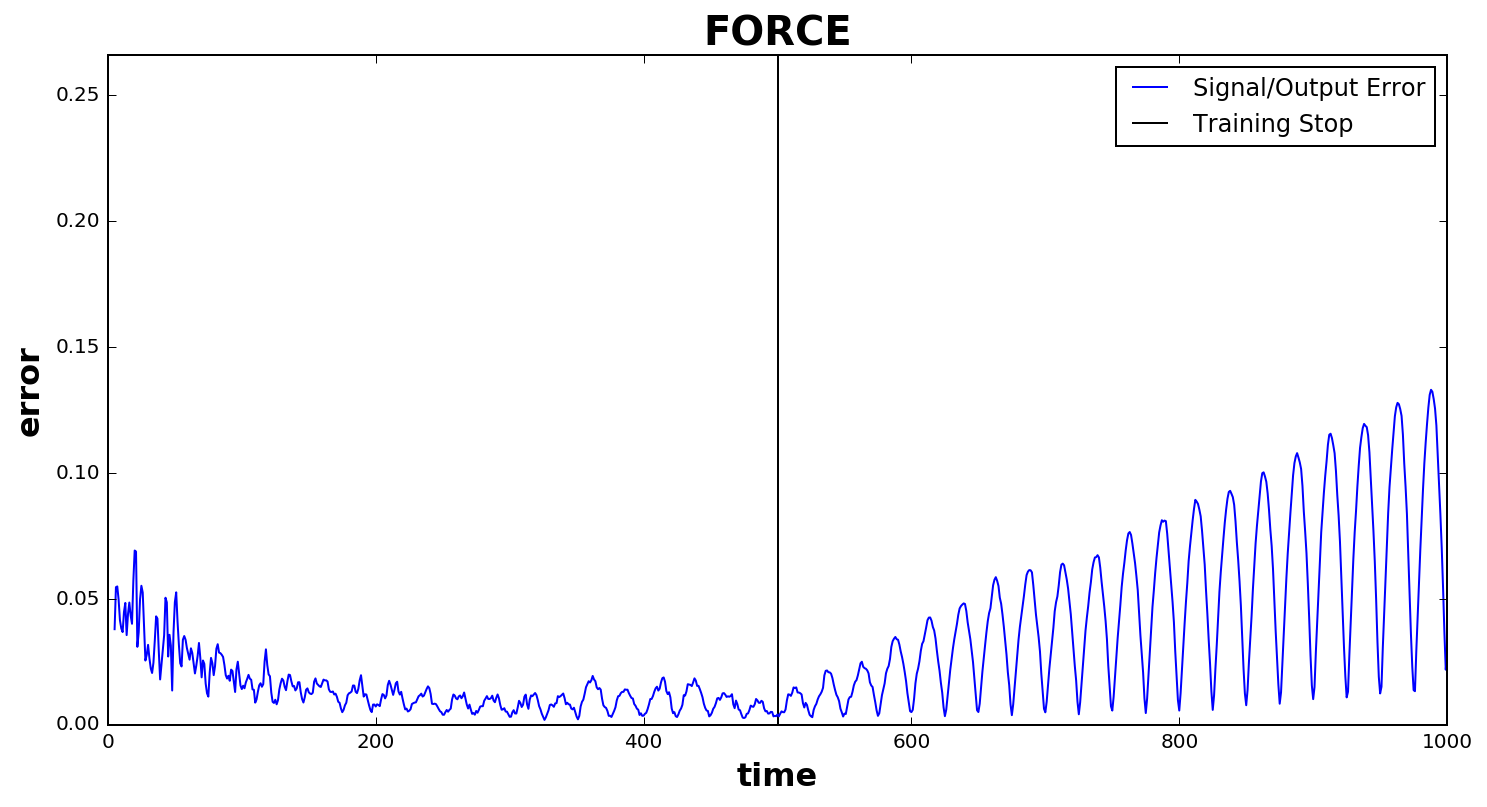

In [53]:
mean_signal_error(errors, t, tstop, title= "FORCE", burn_in=5)

In [13]:
# Simulation Parameters for DFORCE
lr = .4
rho = repeat(0.05, N)

In [10]:
derrors = []

for seed in seeds:
    J, _, _, x0, u, w, = set_simulation_parameters(seed, N, 1)
    
    def model(t0, x, tanh_x, w, inp, z): 
        return -x + g * dot(J, tanh_x) + dot(w, tanh_x) * u
    
    x,t,z,_,_ = jedi.dforce(rho, target, model, lr, dt, tmax, tstop, x0, w)

    derror = np.abs(z-target(t))
    derrors.append(derror)
    
derrors = np.array(derrors)

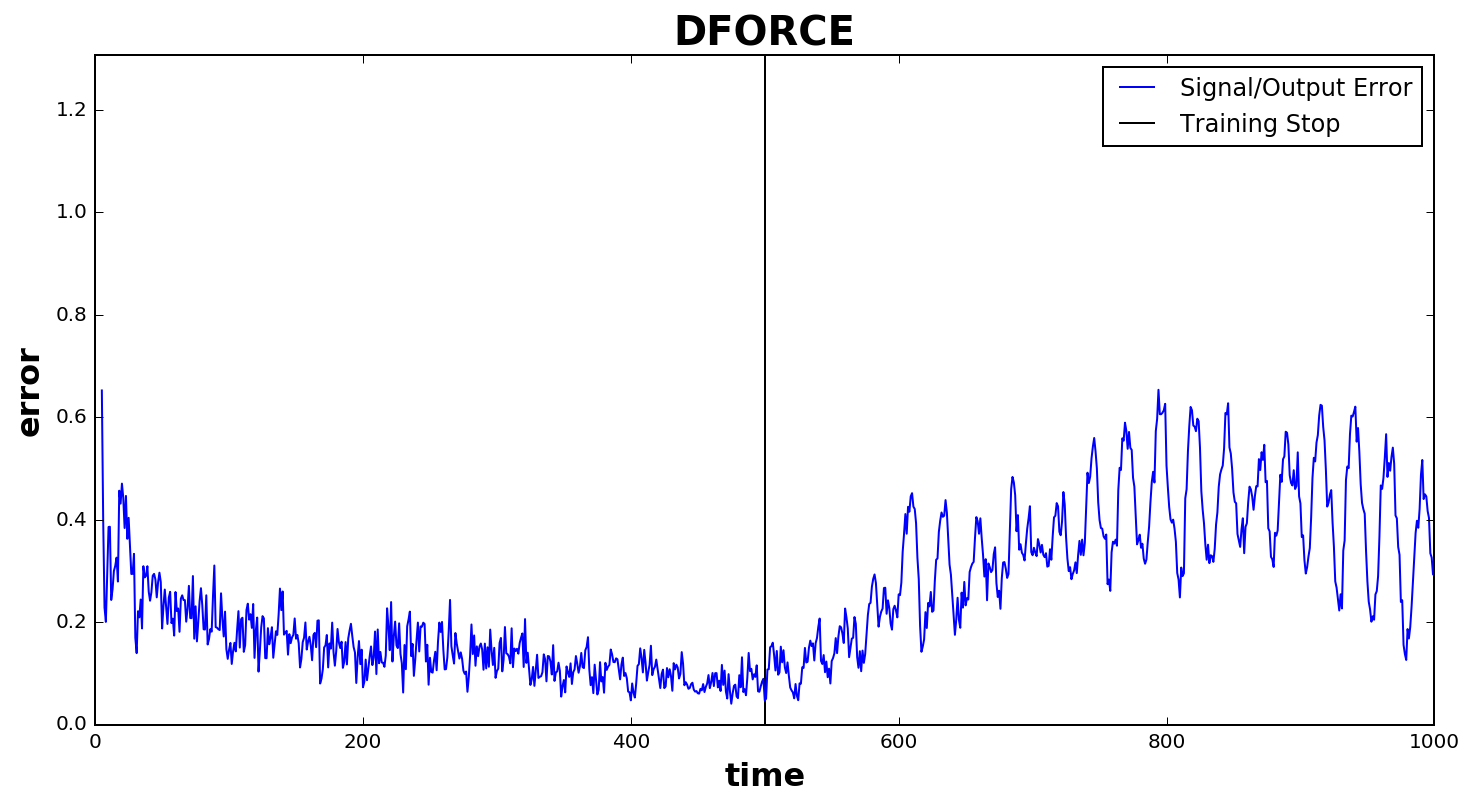

In [54]:
mean_signal_error(derrors, t, tstop, title="DFORCE", burn_in=5)

1.30690745214


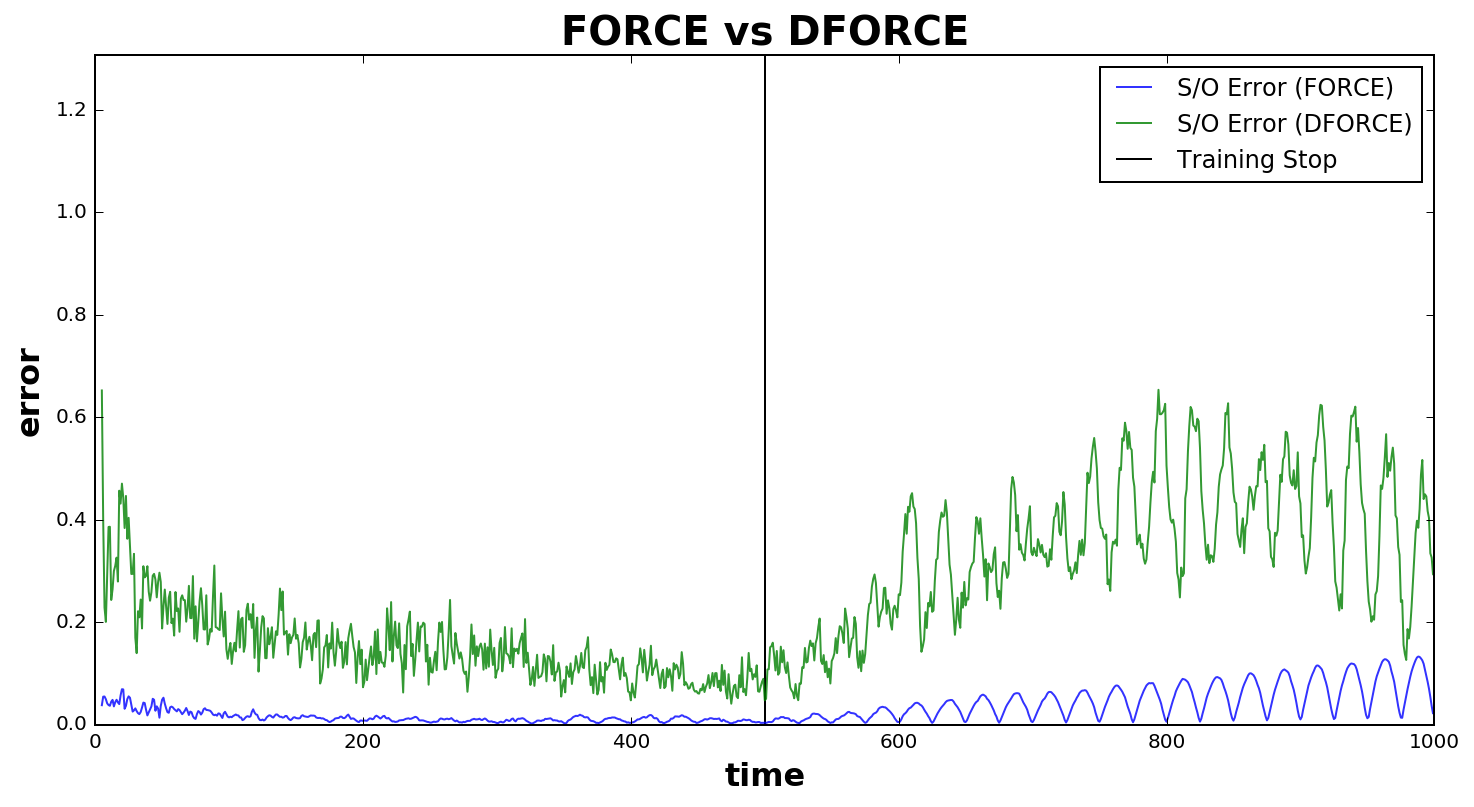

In [55]:
cross_mean_signal_error(errors, derrors, t, tstop, title="FORCE vs DFORCE", burn_in=5)

In [56]:
dt = 1       # time step
tmax = 1000   # simulation length
tstop = 500  # learning stop time
g = 1.5      # gain factor?
N = 300     # size of stochastic pool
I = 1    # input size
lr = .8     # learning rat

In [112]:
def gen_inp_targets():
    # Setting targets for flip-flop task
    targets= ones(tmax)
    targets[range(100,231)] = -1
    targets[range(300,351)] = -1
    targets[range(450,501)] = -1
    targets[range(650,751)] = -1
    targets[970:] = -1

    # Setting inputs for flip-flop task
    inputs = zeros(tmax)
    inputs[range(100,111)] = -1
    inputs[range(165,176)] = -1
    inputs[range(230,241)] = 1
    inputs[range(300,311)] = -1
    inputs[range(350,361)] = 1
    inputs[range(450,461)] = -1
    inputs[range(500,511)] = 1
    inputs[range(650,661)] = -1
    inputs[range(750,761)] = 1
    inputs[range(820,831)] = 1
    inputs[range(970,981)] = -1

    inputs = inputs.tolist()
    targets = targets.tolist()
    
    return inputs, targets

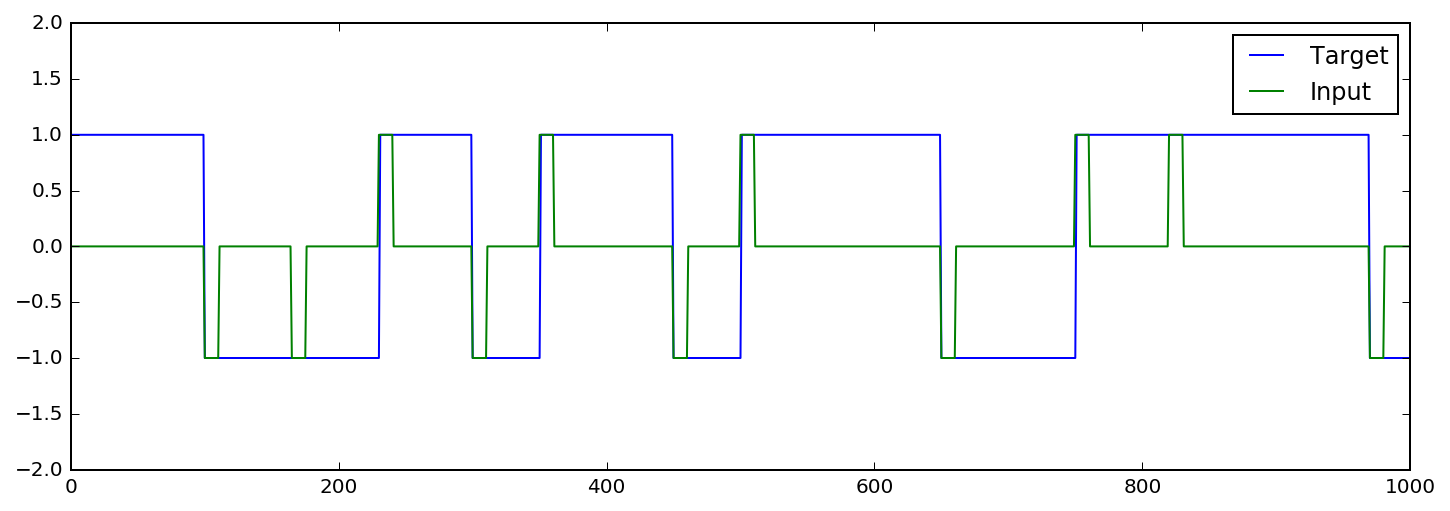

In [113]:
# Plotting inputs and targets
inputs, targets = gen_inp_targets()
plt.figure(figsize=(12, 4))
plt.plot(range(tmax), targets, label="Target");
plt.plot(range(tmax), inputs, label="Input");
plt.ylim(-2,2);
plt.legend();

In [114]:
errors = []
wus = []
zs = []

for seed in seeds:
    J, Wi, wi, x0, u, w = set_simulation_parameters(seed, N, I)
    
    def model(t0, x, tanh_x, w, inp, z):
        return -x + dot(J, tanh_x) + dot(Wi, inp) + dot(wi,z)
    
    x,t,z,_,wu = jedi.force(targets, model, lr, dt, tmax, tstop, x0, w, inputs)
    
    zs.append(z)
    wus.append(wu)
    
    error = np.abs(z[1:]-np.array(targets))
    errors.append(error)
    
errors = np.array(errors)

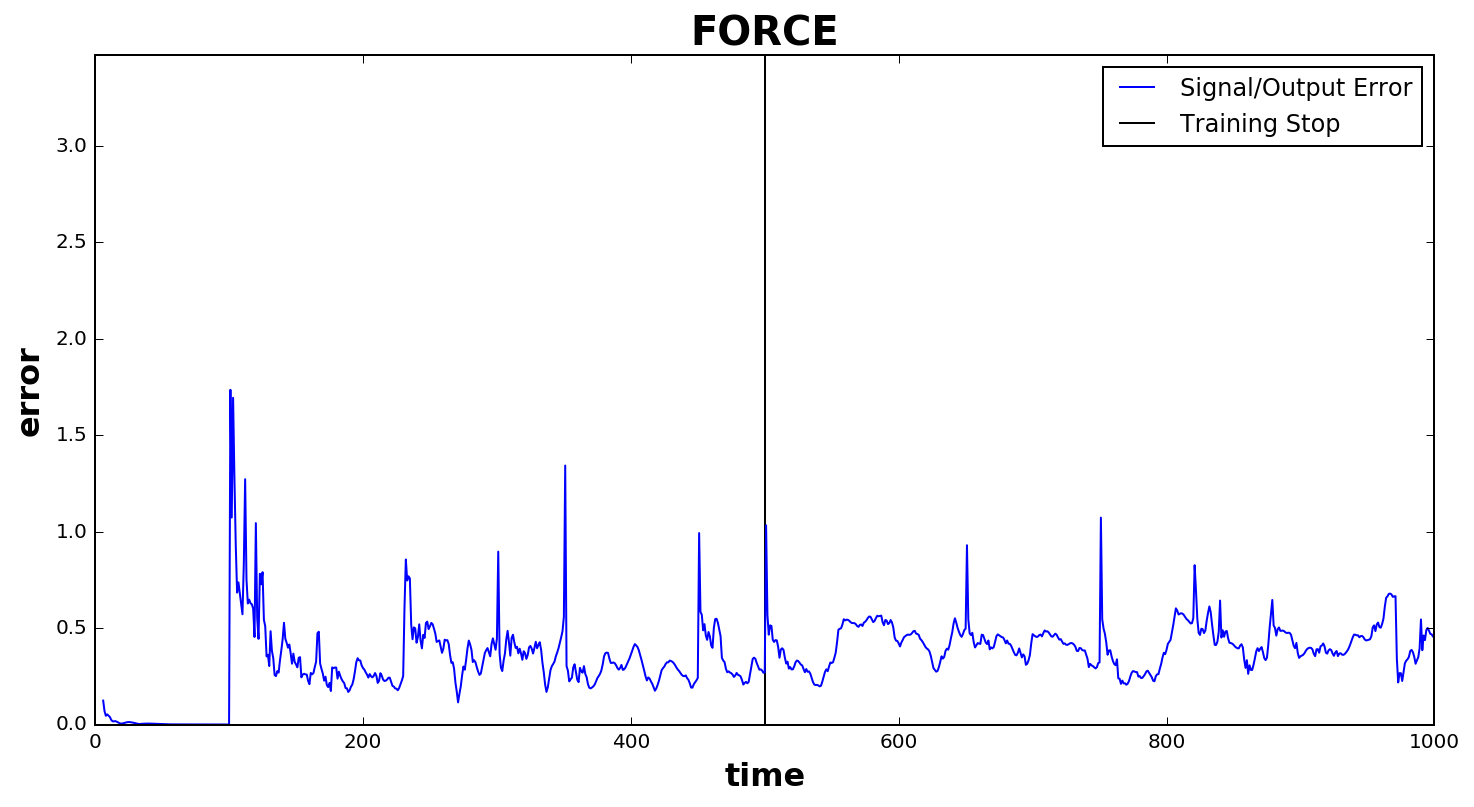

In [60]:
mean_signal_error(errors, t[1:], tstop, title= "FORCE", burn_in=5)

In [75]:
ind = 0

Seed: 0


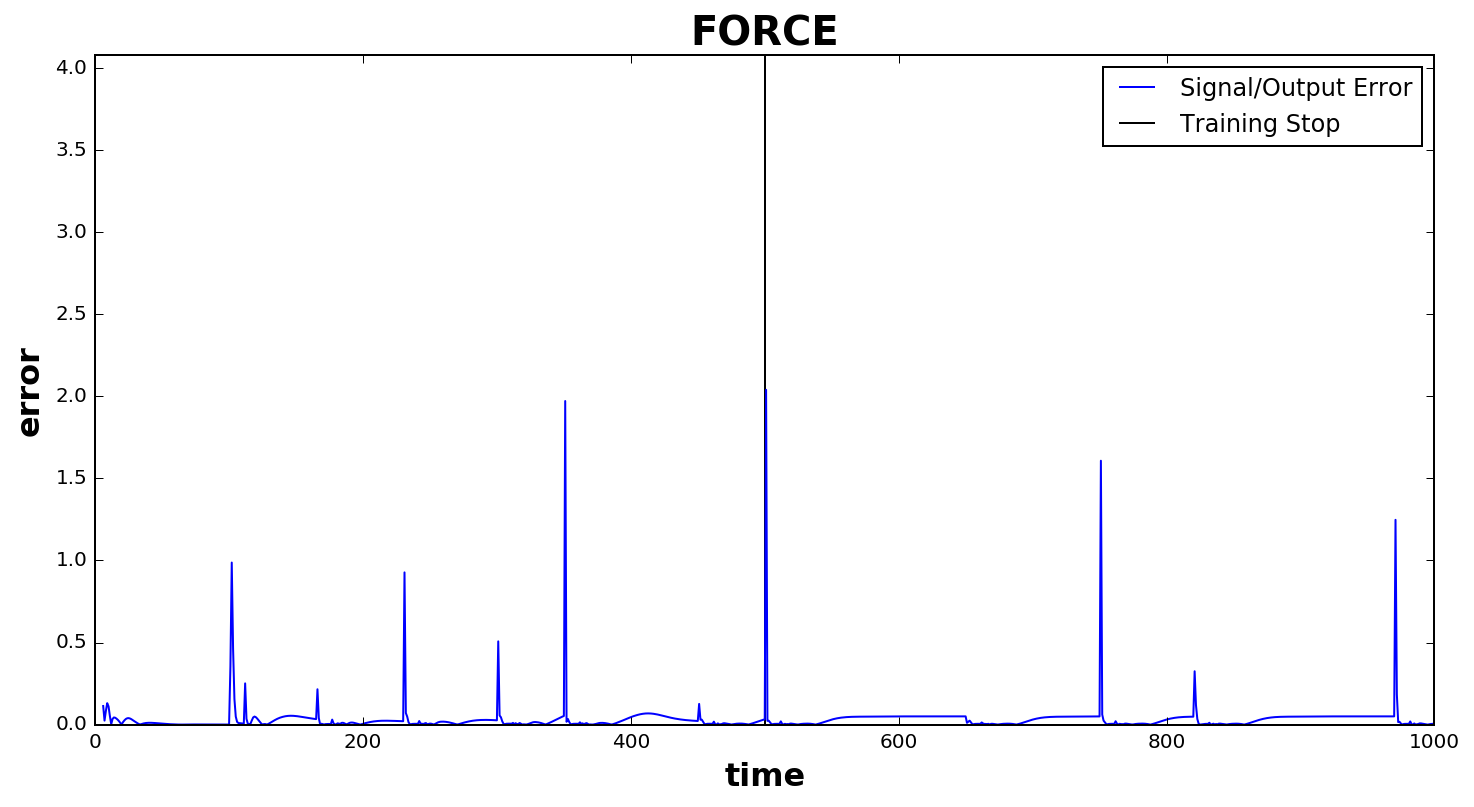

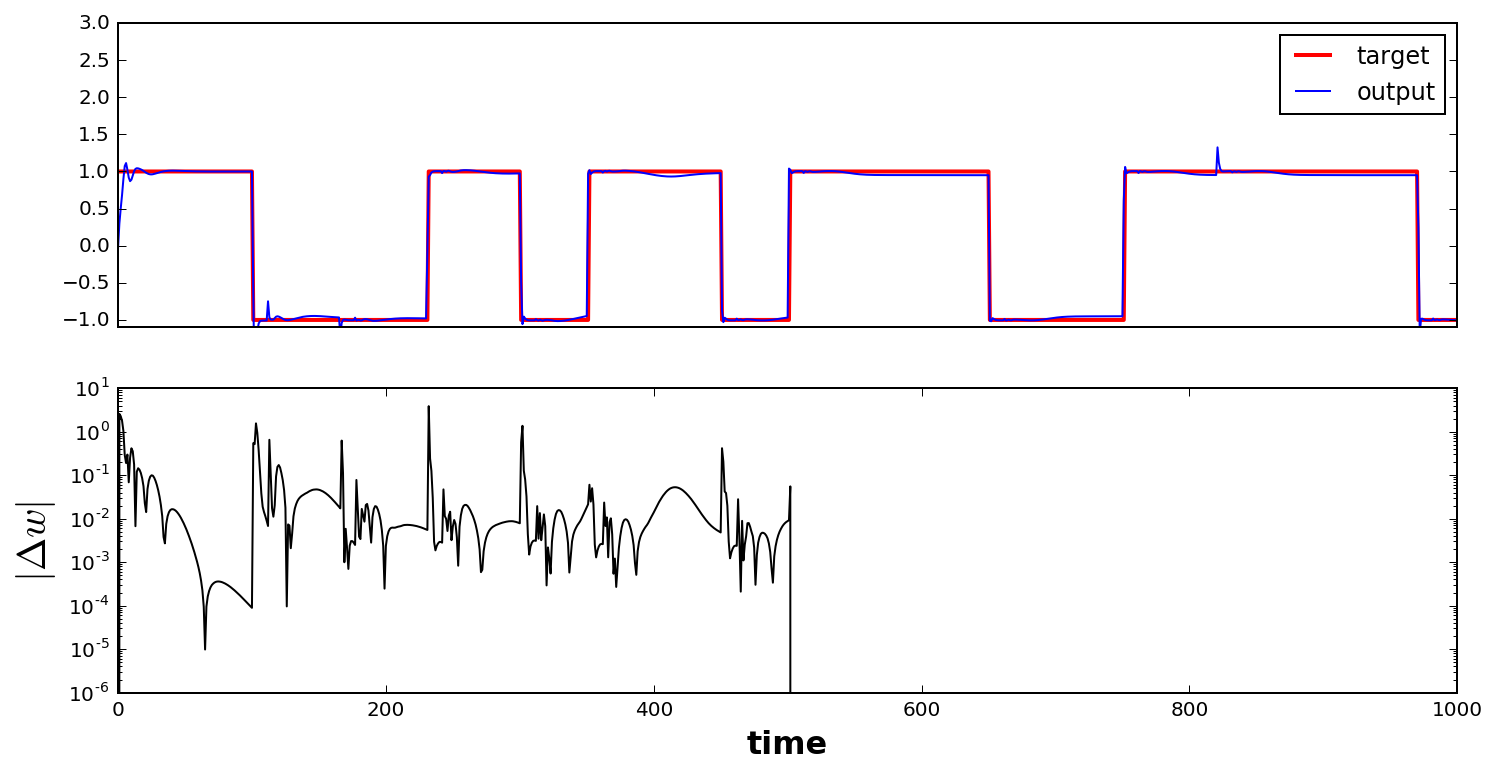

In [76]:
print("Seed: %d" % ind)
mean_signal_error(errors[ind], t[1:], tstop, title= "FORCE", burn_in=5, mean=False)
error_signal_plot(t, zs[ind], wus[ind], targets, offset=1)
ind+=1

In [115]:
derrors = []
wus = []
zs = []

for seed in seeds:
    J, Wi, wi, x0, u, w = set_simulation_parameters(seed, N, 1)
    
    def model(t0, x, tanh_x, w, inp, z):
        return -x + dot(J, tanh_x) + dot(Wi, inp) + dot(wi,z)
    
    x,t,z,_,wu = jedi.dforce(rho, targets, model, lr, dt, tmax, tstop, x0, w, inputs)

    zs.append(z)
    wus.append(wu)
        
    derror = np.abs(z[1:]-np.array(targets))
    derrors.append(derror)
    
derrors = np.array(derrors)

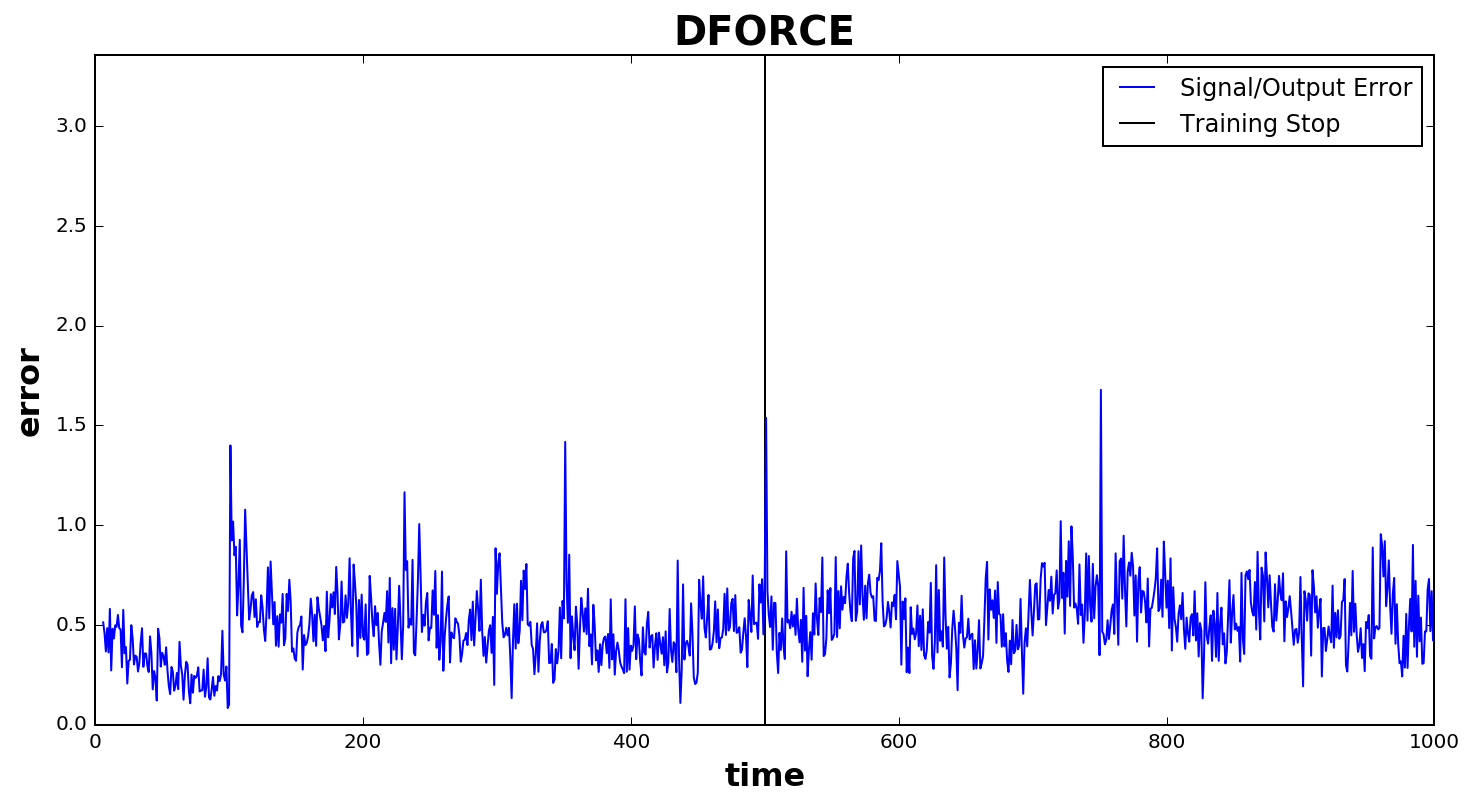

In [79]:
mean_signal_error(derrors, t[1:], tstop, title="DFORCE", burn_in=5)

In [91]:
# Setting seed index
ind = 0

Seed: 1


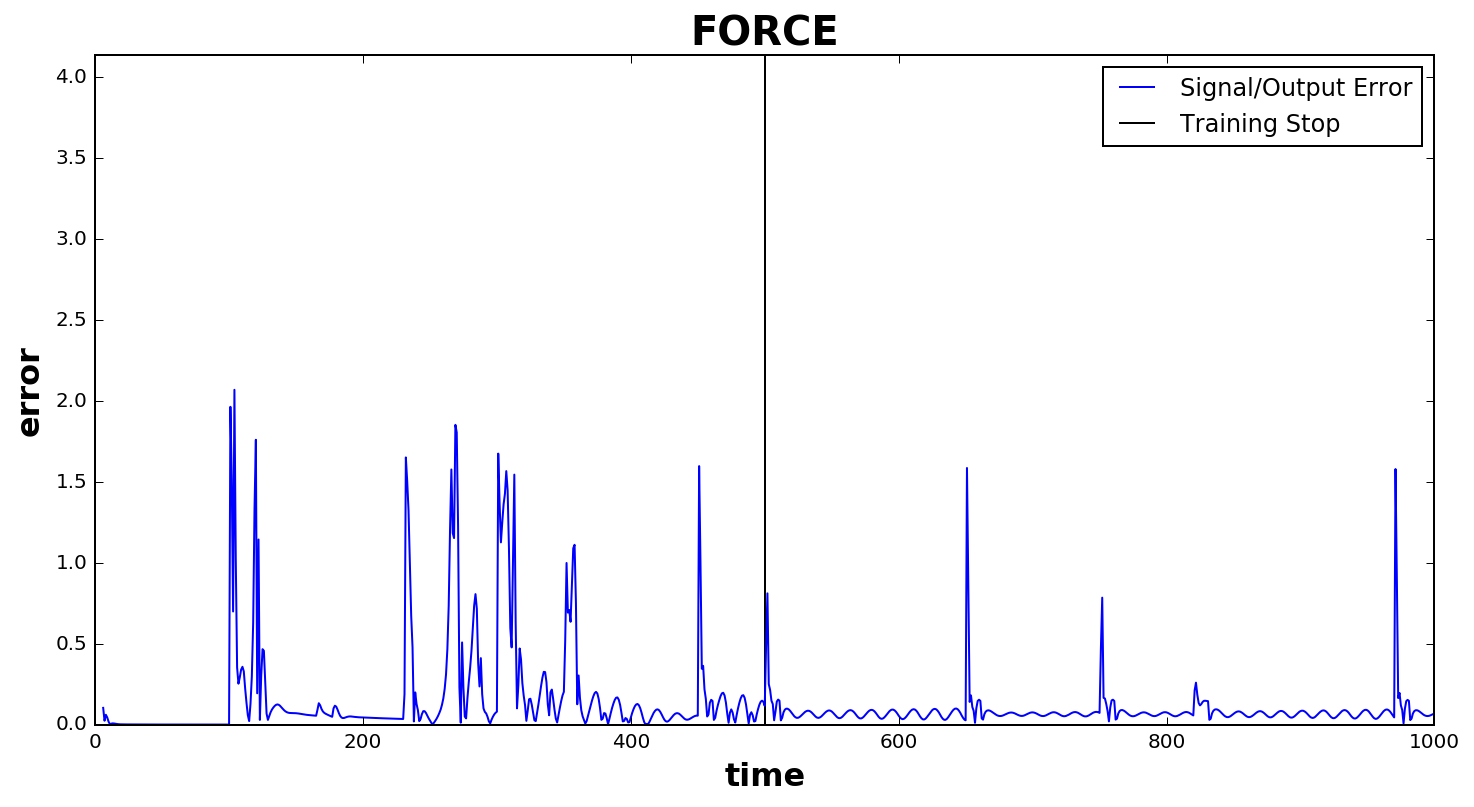

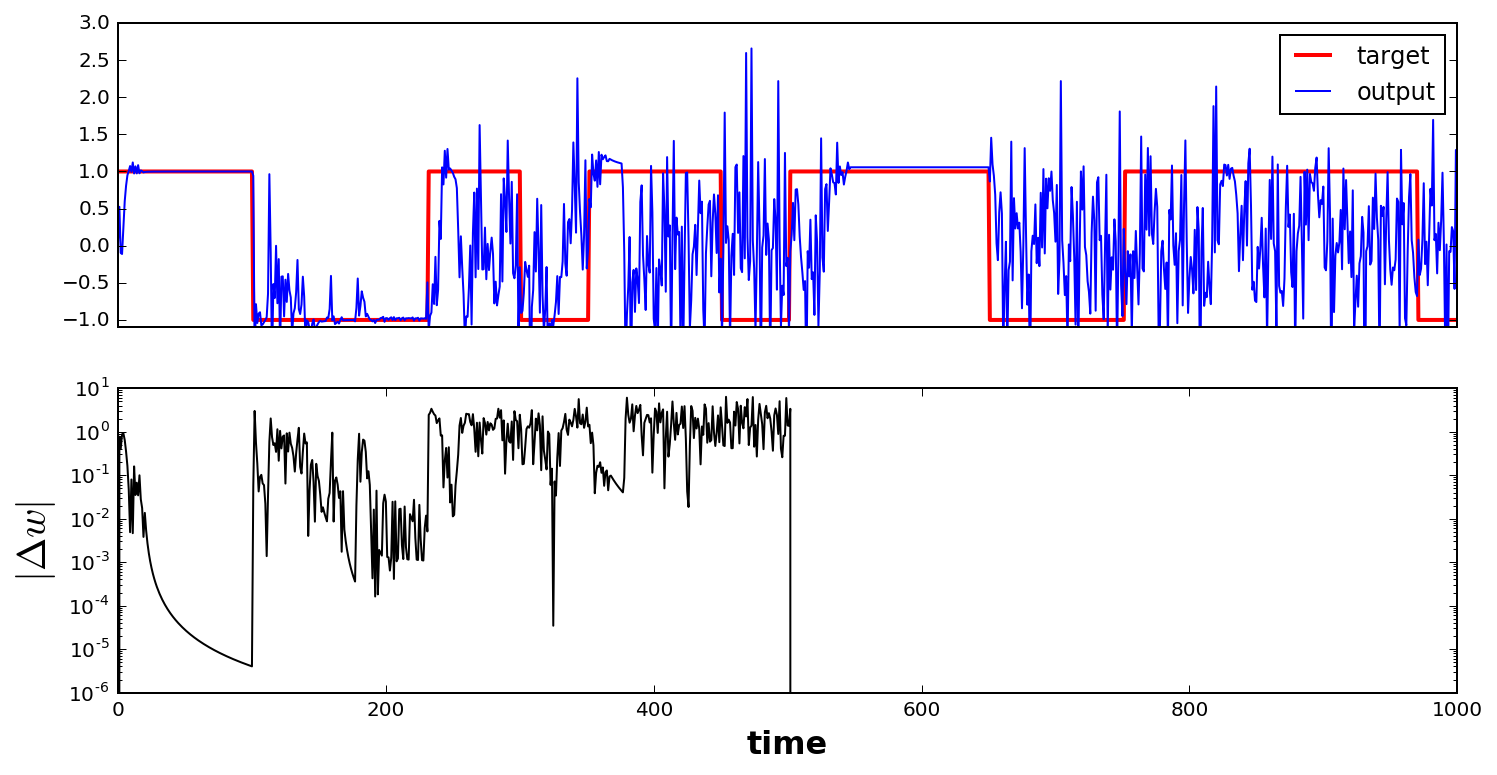

In [116]:
print("Seed: %d" % ind)
mean_signal_error(errors[ind], t[1:], tstop, title= "FORCE", burn_in=5, mean=False)
error_signal_plot(t, zs[ind], wus[ind], targets, offset=1)
ind+=1

3.47053524415


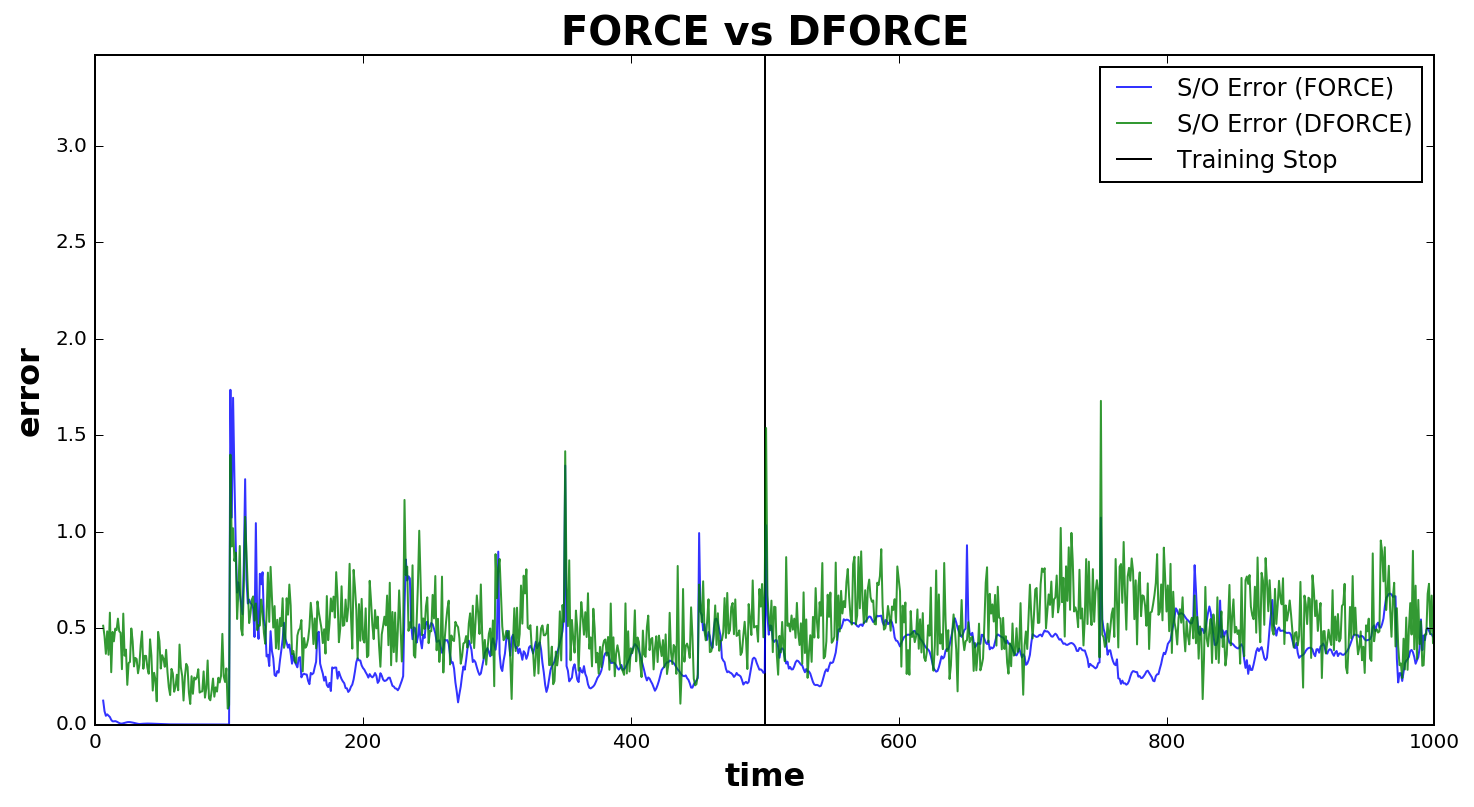

In [82]:
cross_mean_signal_error(errors, derrors, t[1:], tstop, title="FORCE vs DFORCE", burn_in=5)

In [108]:
# Setting seed index
ind = 0

Seed: 6
5.58761944788


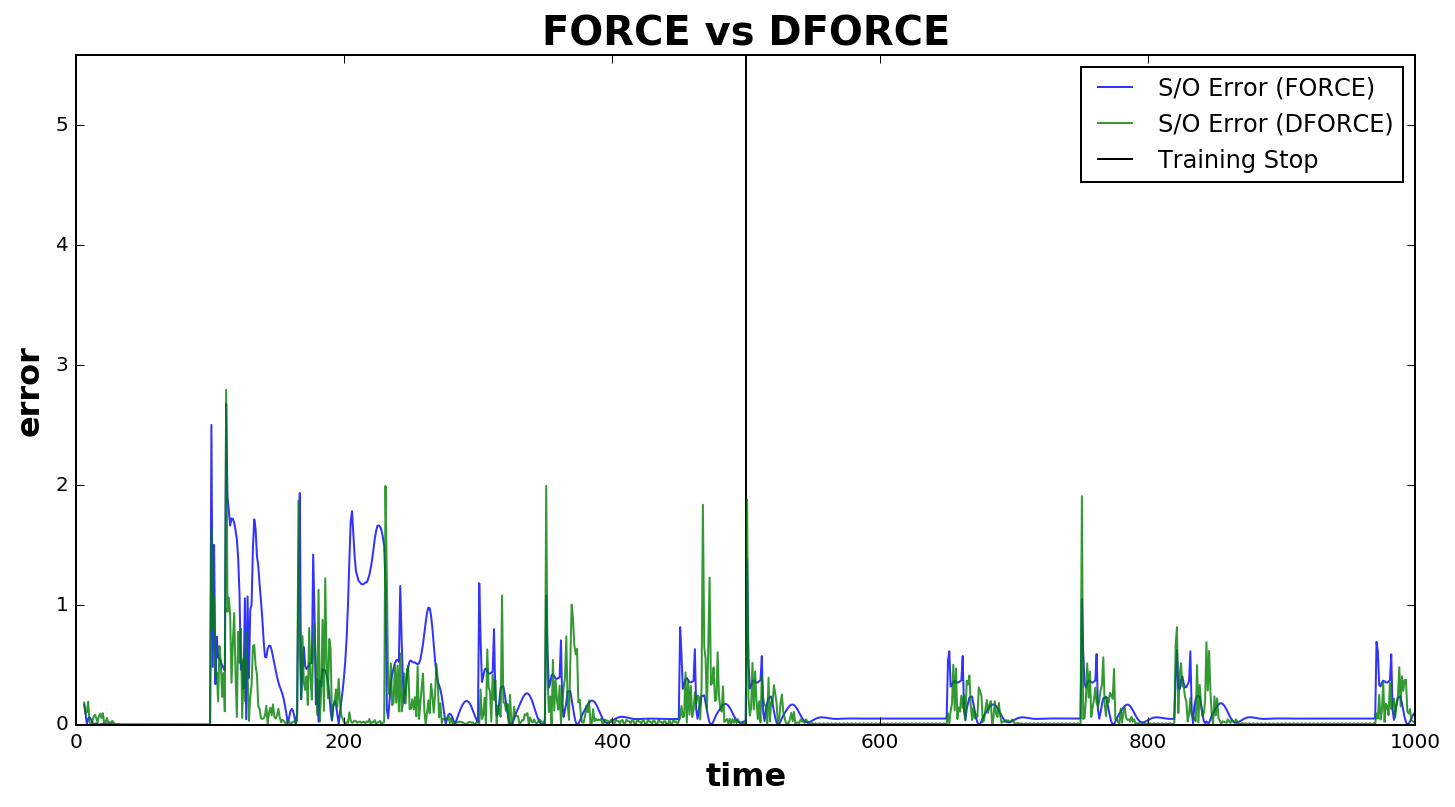

In [121]:
print("Seed: %d" % ind)
cross_mean_signal_error(errors[ind], derrors[ind], t[1:], tstop, title="FORCE vs DFORCE", burn_in=5, mean=False)
ind+=1

# TO-DO

1) Verify functions work
2) Compile lists of functions
3) Read on Stogatz text
4) Read Mass Model and Abbott
